In [1]:
import pandas as pd
import numpy as np
import heartpy as hp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns

### Data Extraction
Output:   actual_systole, actual_diastole, age, weigth, bpm, ibi, ..."PPG Feature"

In [2]:
data = pd.read_csv('data-clean.csv')
data_extraction = pd.DataFrame()

for i, ppg in enumerate(data['ppg']): 
  ppg = list(map(int, ppg.split(',')))

  try:
    data_extraction.at[i, 'actual_systole'] = data.at[i, 'actual_systole']
    data_extraction.at[i, 'actual_diastole'] = data.at[i, 'actual_diastole']
    data_extraction.at[i, 'age'] = data.at[i, 'age']
    data_extraction.at[i, 'weight'] = data.at[i, 'weight']
    wd, m = hp.process(np.array(ppg), sample_rate = 100.0)
    for key, value in m.items():
      data_extraction.at[i, key] = value
  except Exception as e:
    print(f"{i} - {e}")
    
data_extraction = data_extraction.dropna()
data_extraction.to_csv('data-extraction.csv', index = False)

c:\Python310\lib\site-packages\numpy\ma\core.py:5288: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python310\lib\site-packages\pandas\core\internals\blocks.py:985: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Python310\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Python310\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxi

65 - 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------

67 - 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------



c:\Python310\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


### Normalization

In [3]:
data = pd.read_csv('data-extraction.csv')

bp = pd.DataFrame()
bp['actual_systole']= data.pop('actual_systole')
bp['actual_diastole']= data.pop('actual_diastole')

# Create a StandardScaler
standard_scaler = StandardScaler()

# Fit the scaler and transform the data
X_scaler = standard_scaler.fit(data)
joblib.dump(X_scaler, 'scaler.pkl')

standardized_data = pd.DataFrame(X_scaler.transform(data))
standardized_data.columns = data.columns

concatenated_df = pd.concat([bp, standardized_data], axis=1)

concatenated_df.to_csv('data-extraction-normalized.csv', index=False)

### Training Systole

C:\Users\ukisy\AppData\Local\Temp\ipykernel_15744\1493009212.py:33: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


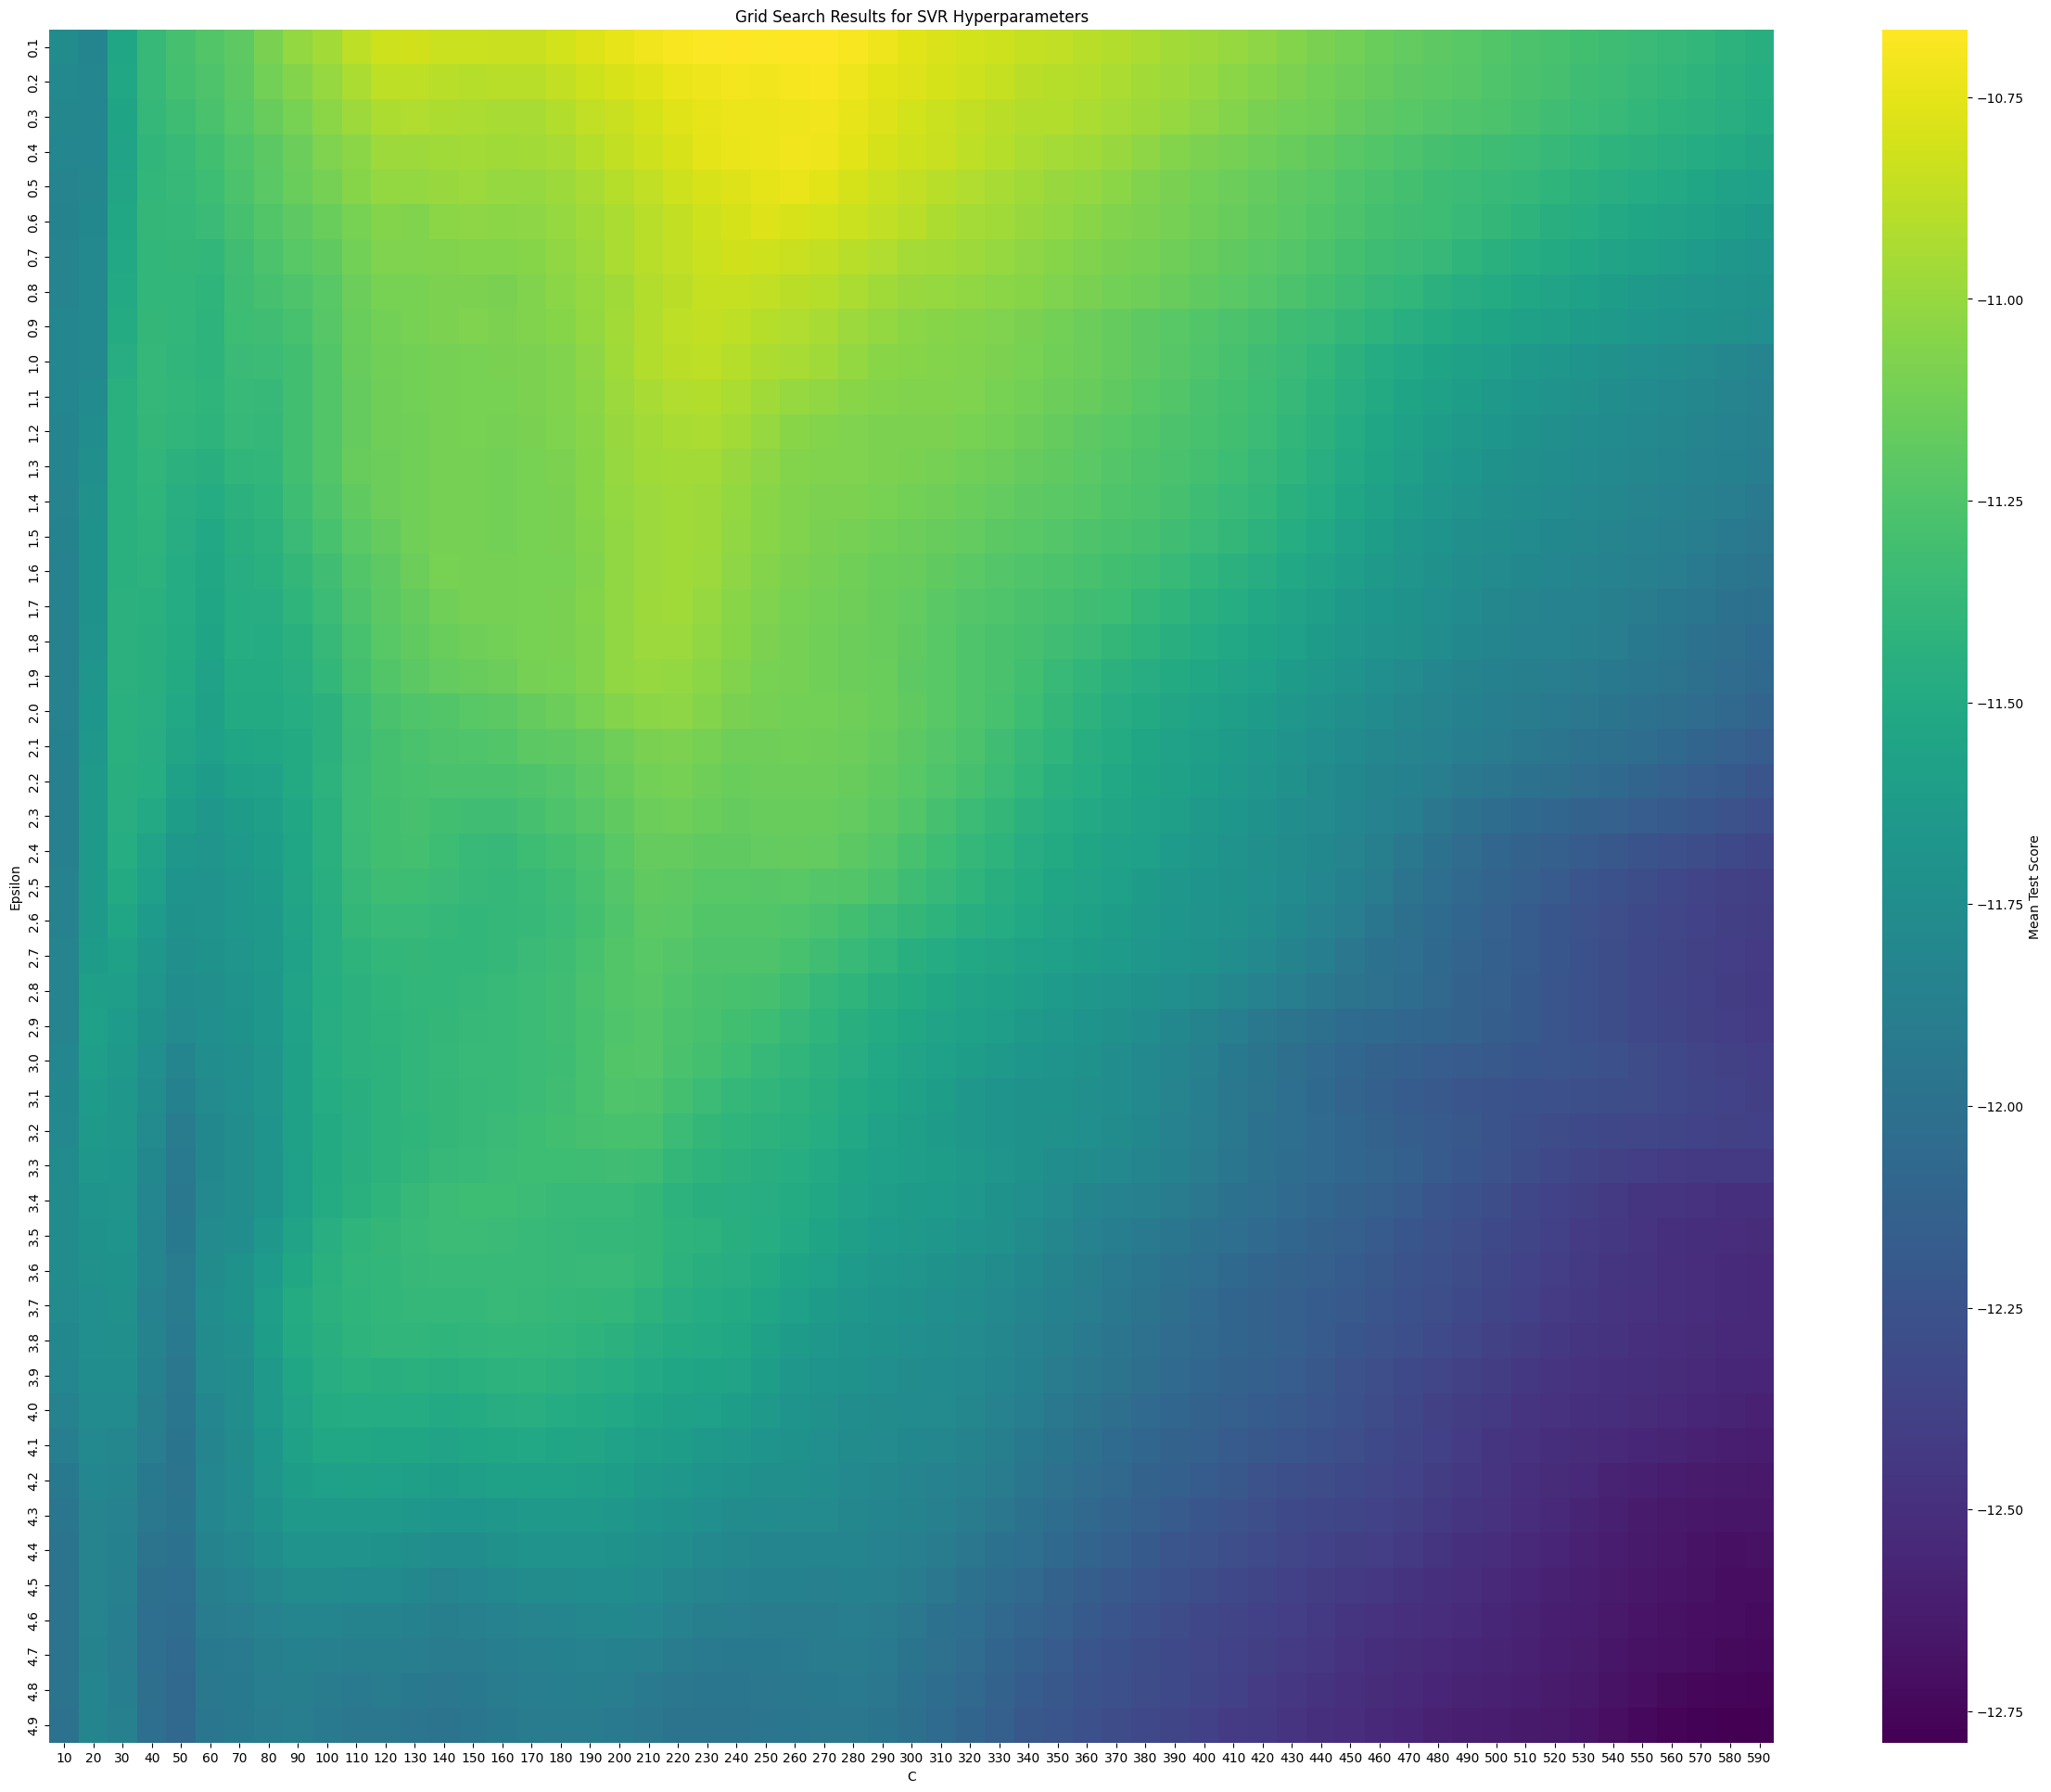

Best hyperparameters: {'C': 270, 'epsilon': 0.1}
With Score: -10.666000597953598


In [14]:
data = pd.read_csv('data-extraction-normalized.csv')

X_y = []

for i in data.columns:
  X_y.append(list(data[i]))
  
X = np.array([X_y[2],X_y[3],X_y[4],X_y[5],]).transpose()
y = np.array(X_y[0])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SVR model
svr = SVR(kernel='rbf')

# Define the parameter grid for hyperparameter tuning
param_grid = {'C': np.round(np.arange(10, 600, 10),1), 'epsilon': np.round(np.arange(0.1, 5, 0.1),1)}

# Create the GridSearchCV object
grid_search = GridSearchCV(svr, param_grid, cv=10, scoring='neg_mean_absolute_error')

# Fit the model with the training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'systole_model.pkl')

# Get the results as a Pandas DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Reshape the results for heatmap
heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')

# Plot the heatmap
plt.figure(figsize=(30, 24))
sns.heatmap(heatmap_data, cmap='viridis', fmt=".4f", cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Results for SVR Hyperparameters')
plt.xlabel('C')
plt.ylabel('Epsilon')
plt.show()

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("With Score:", grid_search.best_score_)

# Training Diastole

In [11]:
np.round(np.arange(0.1, 5, 0.1),1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])

C:\Users\ukisy\AppData\Local\Temp\ipykernel_15744\2157526552.py:33: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


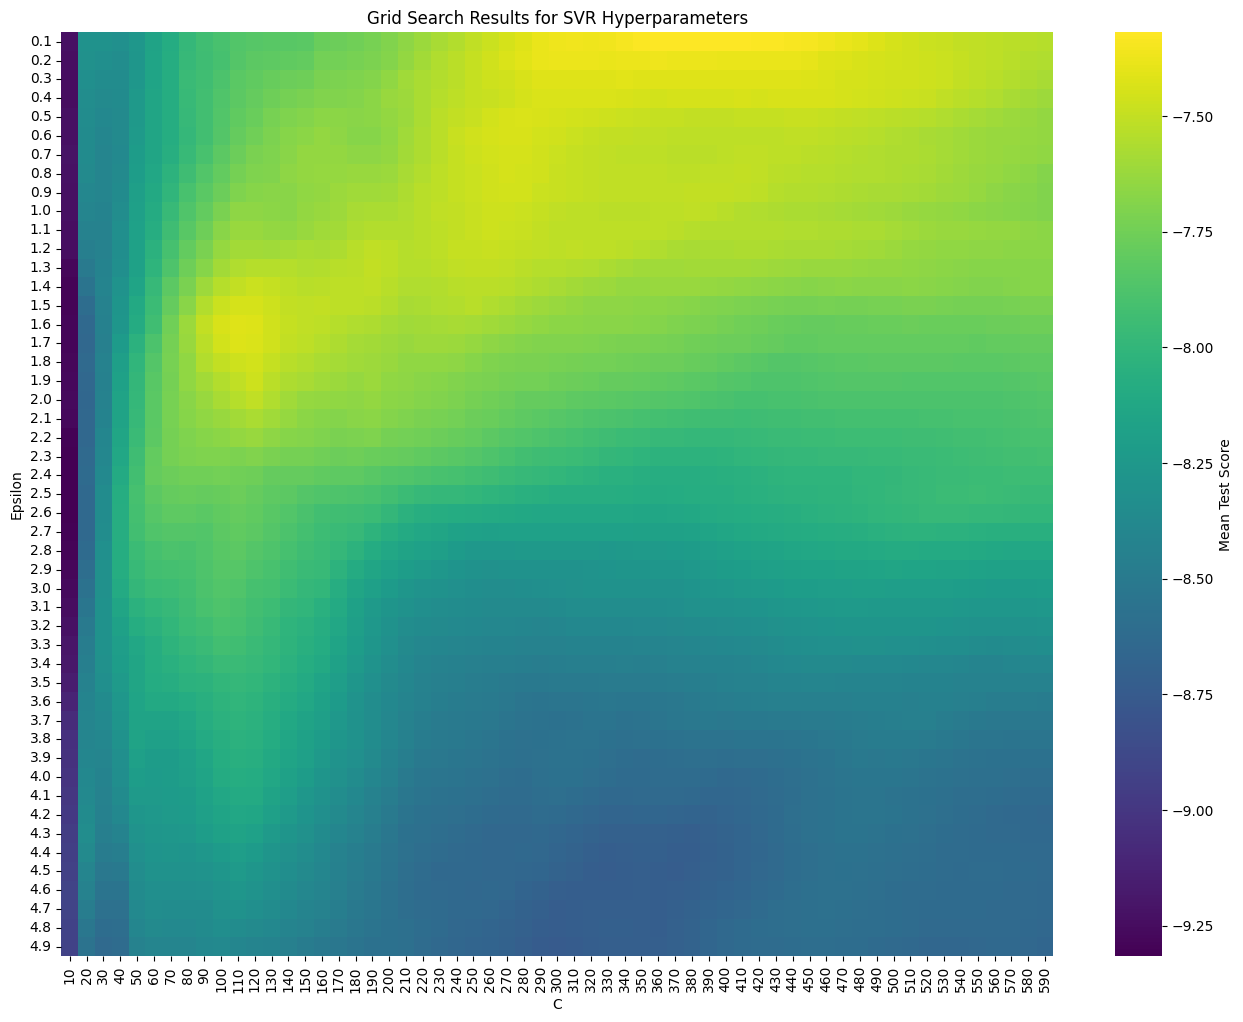

Best hyperparameters: {'C': 370, 'epsilon': 0.1}
With Score: -7.318599703696885


In [12]:
data = pd.read_csv('data-extraction-normalized.csv')

X_y = []

for i in data.columns:
  X_y.append(list(data[i]))
  
X = np.array([X_y[2],X_y[3],X_y[4],X_y[5],]).transpose()
y = np.array(X_y[1])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SVR model
svr = SVR(kernel='rbf')

# Define the parameter grid for hyperparameter tuning
param_grid = {'C': np.round(np.arange(10, 600, 10),1), 'epsilon': np.round(np.arange(0.1, 5, 0.1),1)}

# Create the GridSearchCV object
grid_search = GridSearchCV(svr, param_grid, cv=10, scoring='neg_mean_absolute_error')

# Fit the model with the training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'diastole_model.pkl')

# Get the results as a Pandas DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Reshape the results for heatmap
heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(heatmap_data, cmap='viridis', fmt=".4f", cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Results for SVR Hyperparameters')
plt.xlabel('C')
plt.ylabel('Epsilon')
plt.show()

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("With Score:", grid_search.best_score_)

# Correlation Matrix

pnn50             -0.239251
pnn20             -0.232371
hr_mad            -0.141781
breathingrate     -0.117853
ibi               -0.104785
sd1               -0.093850
rmssd             -0.085303
sd2               -0.080979
s                 -0.077969
sdsd              -0.064958
sdnn              -0.048443
sd1/sd2            0.078529
bpm                0.108288
weight             0.425095
age                0.479472
actual_diastole    0.857261
actual_systole     1.000000
Name: actual_systole, dtype: float64


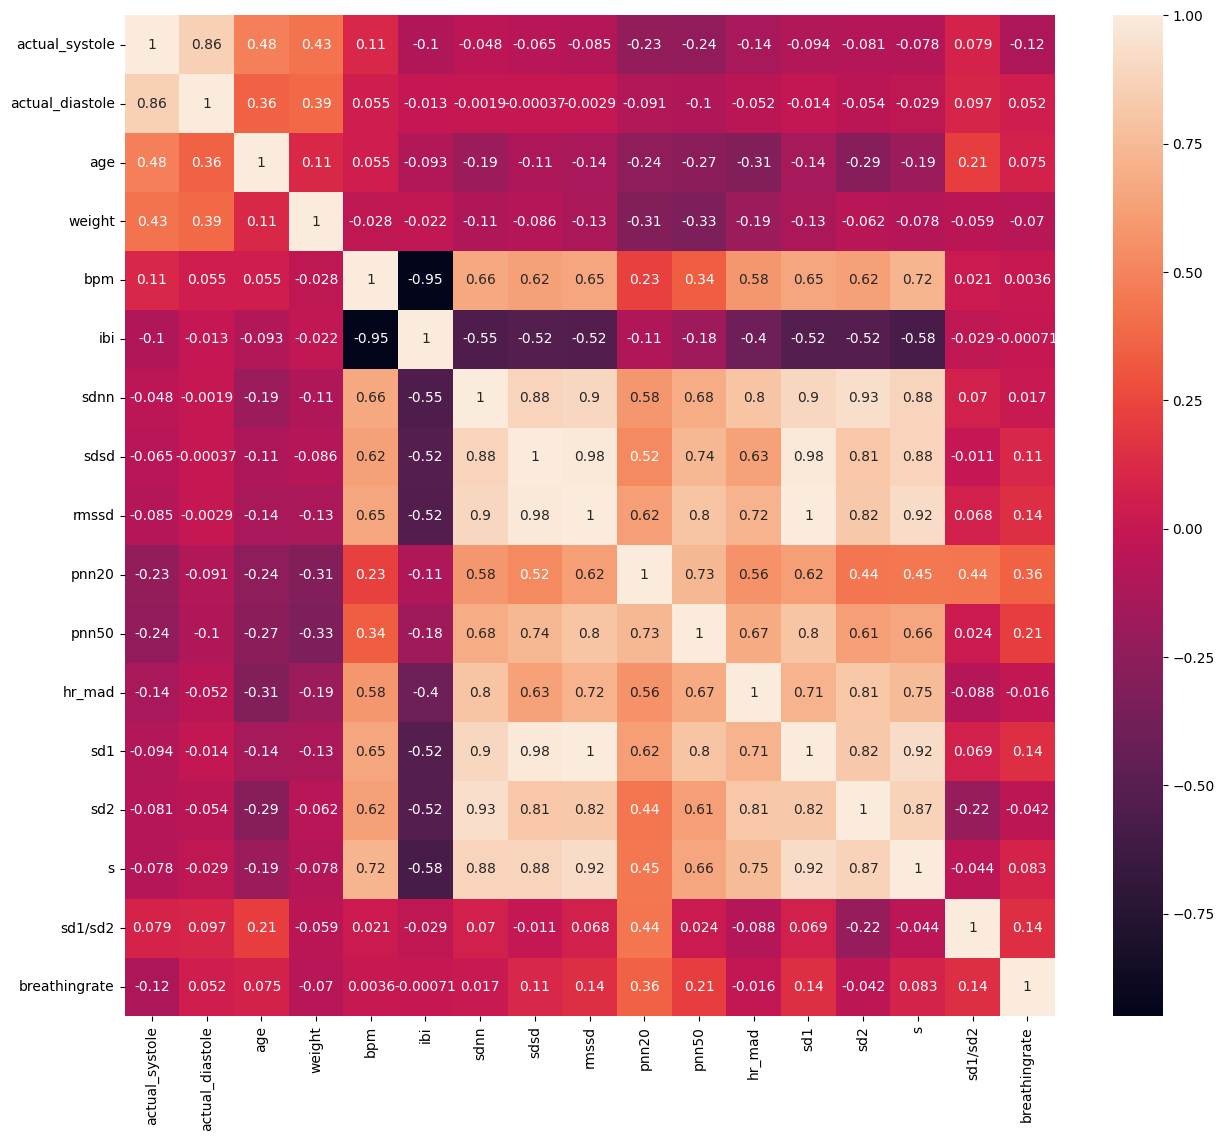

In [6]:
data = pd.read_csv('data-extraction-normalized.csv')

corr_matrix = data.corr()
print(corr_matrix.actual_systole.sort_values())
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix, annot=True)
plt.show()